# Environment settings

### Libraries import

In [70]:
import torch, torchvision

from torch import nn

# Optimizer
from torch import optim

# Image transformation
from torchvision.transforms import ToTensor

import torch.nn.functional as funct

import matplotlib.pyplot as plt

import copy

from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

import requests
from PIL import Image
from io import BytesIO

import tabulate

### General parameters definition

In [7]:
NUM_BATCH = 64

### Data import

In [8]:
# set up a transformation function to transform the data. Useful for complex transformation pipelines.
T = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# import data
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
validation_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

# set a train data loader
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=NUM_BATCH)
validation_data_loader = torch.utils.data.DataLoader(validation_data, batch_size=NUM_BATCH)

In [9]:
print(len(train_data)) # number of images
print(len(train_data[0])) # X=image, y=correct_annotation
print(len(train_data[0][0]))
print(len(train_data[0][0][0])) # number of Pixels x-axis
print(len(train_data[0][0][0][0])) # number of Pixels y-axis

60000
2
1
28
28


Draw a sample image

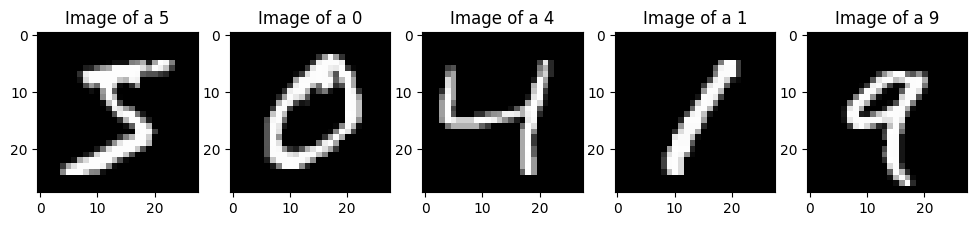

In [10]:
# create figure
fig = plt.figure(figsize=(12, 8))

# add suplots and show images
for i in range(5):
    fig.add_subplot(1, 5, i+1)
    # plot the image from the training dataset
    plt.imshow(train_data[i][0][0], cmap="gray")
    # plot the corresponding title from the training dataset
    plt.title("Image of a {}".format(train_data[i][1]))

plt.show()



# Model

### LeNet Model

In [11]:
def create_lenet_model():
    model = nn.Sequential(
        # 1st convolutional layer
        nn.Conv2d(1, 6, 5, padding=2), # input channel : 1, output channel : 6, kernel size : 5
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),

        # 2nd convolutional layer
        nn.Conv2d(6, 16, 5, padding=0), # input channel : 6, output channel : 16, kernel size : 5
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),

        # Flattening layer and linear layers to go to the digit classification
        nn.Flatten(),

        nn.Linear(400, 120), # 1st linear layer (400 = 16*(5*5) = output size of the last layer * kernel size --> for input, 120 for output is standard Lenet model)
        nn.ReLU(),

        nn.Linear(120, 84), # 2nd linear layer (120 for input, 84 for output, standard Lenet model)
        nn.ReLU(),

        nn.Linear(84, 10) # 3rd linear layer that convert to the 10 arabic digits 
    )
    return model

Validation function

In [12]:
def validate_model(model, data):
    total = 0
    correct = 0

    for i, (images, labels) in enumerate(data):
        # get the prediction from the model
        x = model(images)
        # get the value of the highest prediction
        value, pred = torch.max(x, 1)

        # increment total and correct
        total += x.size(0)
        correct += torch.sum(pred == labels)
    
    return correct*100/total

Training function

In [36]:
def train_model(train_dataloader, validate_dataloader, numb_epoch=3, learning_rate=1e-3, device="cpu"):
    # intialize the model
    cnn = create_lenet_model().to(device)
    # initialize the cross entropy loss function
    cel = nn.CrossEntropyLoss()
    # initialize the optimizer
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
    # initialize accuracy variables
    accuracies = []
    max_accuracy = 0

    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            # reset the gradient
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cel(pred, labels)
            loss.backward() # backward propagation
            optimizer.step()
        accuracy = float(validate_model(cnn, validate_dataloader))
        accuracies.append(accuracy)

        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving best model with accuracy: {}%".format(accuracy))
        print("Epoch: {}, Accuracy: {}%".format(epoch+1, accuracy))
    plt.plot(accuracies)
    plt.xlabel("Number of epoch")
    plt.ylabel("Accuracy [%]")
    plt.show()

    return best_model

Check for GPU availability

In [37]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")

# print the device type
device

No Cuda Available


device(type='cpu')

Train the model

Saving best model with accuracy: 95.86000061035156%
Epoch: 1, Accuracy: 95.86000061035156%
Saving best model with accuracy: 97.19999694824219%
Epoch: 2, Accuracy: 97.19999694824219%
Saving best model with accuracy: 97.81999969482422%
Epoch: 3, Accuracy: 97.81999969482422%


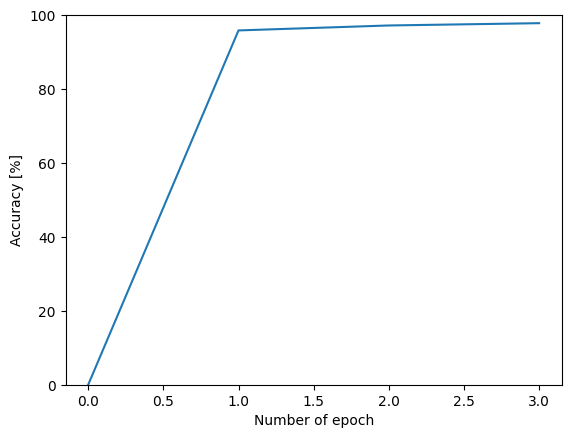

In [35]:
lenet = train_model(train_data_loader, validation_data_loader, numb_epoch=10, device=device)

Prediction function for data loader

In [38]:
def predict_data_loader(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        # define the model
        x = model(images)
        # predict the output values according to the model
        value, pred = torch.max(x, 1)
        # store the predicted values in a list
        y_pred.extend(list(pred.numpy()))
        # store the correct labels from the dataset in a list
        y_true.extend(list(labels.numpy()))

    return np.array(y_pred), np.array(y_true)

In [39]:
y_pred, y_true = predict_data_loader(lenet, validation_data_loader)

Plot the confusion matrix

In [40]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0, 10)))

,0,1,2,3,4,5,6,7,8,9
0,974,0,0,0,0,1,0,1,4,0
1,0,1134,0,1,0,0,0,0,0,0
2,0,5,1022,3,0,0,0,2,0,0
3,0,0,4,996,0,5,0,5,0,0
4,1,2,1,0,968,0,1,3,0,6
5,1,0,0,14,0,875,0,1,1,0
6,7,5,3,0,7,34,897,0,5,0
7,1,8,12,1,0,0,0,1002,1,3
8,1,0,6,19,2,0,0,3,939,4
9,3,6,1,6,8,3,0,6,1,975


Test the LeNet model on various digits images

Inference function

In [45]:
def inference_function(path, model, device):
    # get the image from its path
    r = requests.get(path)
    # apply basic transformation to the image to fit the requested dimensions (28x28)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.

    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return funct.softmax(pred, dim=-1).cpu().numpy()

Test the model on a random image on the Internet

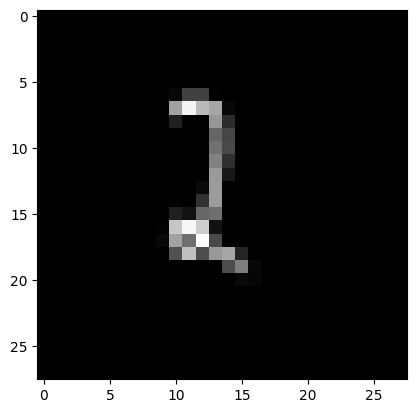

In [64]:
# Find an image on the internet, store its adress into path, plot the image and store its label
path = "https://ak7.picdn.net/shutterstock/videos/23708587/thumb/1.jpg?ip=x480"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
    x = (255 - np.expand_dims(np.array(img), -1))/255.

plt.imshow(x.squeeze(-1), cmap="gray")
plt.show()

In [65]:
# make the prediction using the LeNet model

pred = inference_function(path, lenet, device=device)
# get the index for the highest confidence prediction
pred_idx = np.argmax(pred)
print("Predicted: {}, Probability: {:%}".format(pred_idx, pred[0][pred_idx]))

Predicted: 2, Probability: 47.078103%


In [76]:
df = pd.DataFrame(pred, columns=np.arange(0,10), index=['probability'])
df

,0,1,2,3,4,5,6,7,8,9
probability,0.011133,0.175383,0.470781,0.157046,0.024327,0.071989,0.004421,0.034072,0.039594,0.011254


Low probability since the image is very bad, we can easily confuse between 1 and 2.


We can try with a different image:

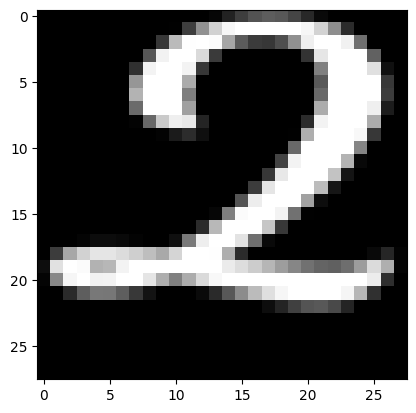

In [59]:
# Find an image on the internet, store its adress into path, plot the image and store its label
path = "https://suncatcherstudio.com/uploads/lettering-fonts/cursive-letters-font/svg/cursive-letters-font-number-2-020202-010101.png"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
    x = (255 - np.expand_dims(np.array(img), -1))/255.

plt.imshow(x.squeeze(-1), cmap="gray")
plt.show()

In [60]:
# make the prediction using the LeNet model

pred = inference_function(path, lenet, device=device)
# get the index for the highest confidence prediction
pred_idx = np.argmax(pred)
print("Predicted: {}, Probability: {:%}".format(pred_idx, pred[0][pred_idx]))

Predicted: 2, Probability: 99.676991%


Now, we get a very high probability since the image is clearly a 2.